# Kaggle San Francisco Crime Classification
## Berkeley MIDS W207 Final Project: Sam Goodgame, Sarah Cha, Kalvin Kao, Bryan Moore



### Environment and Data

In [2]:
# Additional Libraries
%matplotlib inline
import matplotlib.pyplot as plt

# Import relevant libraries:
import time
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import log_loss
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
# Import Meta-estimators
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
# Import Calibration tools
from sklearn.calibration import CalibratedClassifierCV

# Set random seed and format print output:
np.random.seed(0)
np.set_printoptions(precision=3)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


### Local, individual load of updated data set (with weather data integrated) into training, development, and test subsets.


In [3]:
# Data path to your local copy of Kalvin's "x_data.csv", which was produced by the negated cell above
data_path = "./data/x_data_3.csv"
df = pd.read_csv(data_path, header=0)
x_data = df.drop('category', 1)
y = df.category.as_matrix()

# Impute missing values with mean values:
#x_complete = df.fillna(df.mean())
x_complete = x_data.fillna(x_data.mean())
X_raw = x_complete.as_matrix()

# Scale the data between 0 and 1:
X = MinMaxScaler().fit_transform(X_raw)

# Shuffle data to remove any underlying pattern that may exist.  Must re-run random seed step each time:
np.random.seed(0)
shuffle = np.random.permutation(np.arange(X.shape[0]))
X, y = X[shuffle], y[shuffle]

print(np.where(y == 'TREA'))
print(np.where(y == 'PORNOGRAPHY/OBSCENE MAT'))

## Due to difficulties with log loss and set(y_pred) needing to match set(labels), we will remove the extremely rare
## crimes from the data for quality issues.
#X_minus_trea = X[np.where(y != 'TREA')]
#y_minus_trea = y[np.where(y != 'TREA')]
#X_final = X_minus_trea[np.where(y_minus_trea != 'PORNOGRAPHY/OBSCENE MAT')]
#y_final = y_minus_trea[np.where(y_minus_trea != 'PORNOGRAPHY/OBSCENE MAT')]

## Separate training, dev, and test data:
#test_data, test_labels = X_final[800000:], y_final[800000:]
#dev_data, dev_labels = X_final[700000:800000], y_final[700000:800000]
#train_data, train_labels = X_final[100000:700000], y_final[100000:700000]
#calibrate_data, calibrate_labels = X_final[:100000], y_final[:100000]

test_data, test_labels = X[800000:], y[800000:]
dev_data, dev_labels = X[700000:800000], y[700000:800000]
#train_data, train_labels = X[100000:700000], y[100000:700000]
train_data, train_labels = X[:700000], y[:700000]
#calibrate_data, calibrate_labels = X[:100000], y[:100000]

# Create mini versions of the above sets
#mini_train_data, mini_train_labels = X_final[:20000], y_final[:20000]
#mini_calibrate_data, mini_calibrate_labels = X_final[19000:28000], y_final[19000:28000]
#mini_dev_data, mini_dev_labels = X_final[49000:60000], y_final[49000:60000]

#mini_train_data, mini_train_labels = X[:20000], y[:20000]
mini_train_data, mini_train_labels = X[:200000], y[:200000]
#mini_calibrate_data, mini_calibrate_labels = X[19000:28000], y[19000:28000]
mini_dev_data, mini_dev_labels = X[430000:480000], y[430000:480000]

## Create list of the crime type labels.  This will act as the "labels" parameter for the log loss functions that follow
#crime_labels = list(set(y_final))
#crime_labels_mini_train = list(set(mini_train_labels))
#crime_labels_mini_dev = list(set(mini_dev_labels))
#crime_labels_mini_calibrate = list(set(mini_calibrate_labels))
#print(len(crime_labels), len(crime_labels_mini_train), len(crime_labels_mini_dev),len(crime_labels_mini_calibrate))

crime_labels = list(set(y))
crime_labels_mini_train = list(set(mini_train_labels))
crime_labels_mini_dev = list(set(mini_dev_labels))
#crime_labels_mini_calibrate = list(set(mini_calibrate_labels))
#print(len(crime_labels), len(crime_labels_mini_train), len(crime_labels_mini_dev),len(crime_labels_mini_calibrate))
print(len(crime_labels), len(crime_labels_mini_train), len(crime_labels_mini_dev))

print(len(train_data),len(train_labels))
print(len(dev_data),len(dev_labels))
print(len(mini_train_data),len(mini_train_labels))
print(len(mini_dev_data),len(mini_dev_labels))
print(len(test_data),len(test_labels))
#print(len(mini_calibrate_data),len(mini_calibrate_labels))
#print(len(calibrate_data),len(calibrate_labels))

(array([ 39195,  69757, 347976, 450980, 467488, 777371], dtype=int64),)
(array([  6630, 173114, 181454, 239577, 256637, 256880, 300524, 371552,
       378220, 433978, 491311, 537117, 542223, 614805, 622486, 733540,
       777032, 787625, 801668, 806897, 813648, 817548], dtype=int64),)
39 39 39
700000 700000
100000 100000
200000 200000
50000 50000
78049 78049


### Logistic Regression

###### Hyperparameter tuning:

For the Logistic Regression classifier, we can seek to optimize the following classifier parameters: penalty (l1 or l2), C (inverse of regularization strength), solver ('newton-cg', 'lbfgs', 'liblinear', or 'sag')

###### Model calibration:

See above


In [47]:
#log_reg = LogisticRegression(penalty='l1').fit(mini_train_data, mini_train_labels)
#log_reg = LogisticRegression().fit(mini_train_data, mini_train_labels)

In [48]:
#eval_prediction_probabilities = log_reg.predict_proba(mini_dev_data)
#eval_predictions = log_reg.predict(mini_dev_data)
#print("Multi-class Log Loss:", log_loss(y_true = mini_dev_labels, y_pred = eval_prediction_probabilities, labels = crime_labels_mini_dev), "\n\n")

Multi-class Log Loss: 2.59431417646 




In [49]:
#columns = ['hour_of_day','dayofweek',\
#          'x','y','bayview','ingleside','northern',\
#          'central','mission','southern','tenderloin',\
#          'park','richmond','taraval','HOURLYDRYBULBTEMPF',\
#          'HOURLYRelativeHumidity','HOURLYWindSpeed',\
#          'HOURLYSeaLevelPressure','HOURLYVISIBILITY',\
#          'Daylight']
##print(len(columns))
#allCoefs = pd.DataFrame(index=columns)
#for a in range(len(log_reg.coef_)):
#    #print(crime_labels_mini_dev[a])
#    #print(pd.DataFrame(log_reg.coef_[a], index=columns))
#    allCoefs[crime_labels_mini_dev[a]] = log_reg.coef_[a]
#    #print()
#allCoefs

,LOITERING,SECONDARY CODES,BRIBERY,DRUNKENNESS,PROSTITUTION,LARCENY/THEFT,RUNAWAY,DISORDERLY CONDUCT,FRAUD,VEHICLE THEFT,...,TREA,RECOVERED VEHICLE,KIDNAPPING,TRESPASS,LIQUOR LAWS,DRIVING UNDER THE INFLUENCE,PORNOGRAPHY/OBSCENE MAT,VANDALISM,ASSAULT,ARSON
hour_of_day,-0.724234,-0.423226,-2.749641,-0.453286,-0.110932,-1.173416,-0.772314,0.475598,-0.394546,-2.270252,...,-1.227179,-0.158711,0.333270,-0.433817,0.000000,-0.526782,-0.006952,0.736221,-0.038588,-0.083939
dayofweek,-0.075463,0.188465,-1.115896,0.000000,-0.155853,-0.107303,0.424112,-0.211126,0.305433,-0.560482,...,0.000000,-0.193669,0.000000,-0.096629,0.000000,-0.200960,0.247618,0.074116,-0.168756,-0.052224
x,0.000000,2.844481,0.000000,0.000000,0.000000,1.446234,0.000000,-16.131554,0.000000,0.000000,...,0.000000,0.000000,0.000000,-1.027878,0.000000,0.000000,0.000000,-7.812532,0.544292,0.000000
y,0.000000,-2.590312,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.777138,0.000000,0.000000
bayview,1.260006,0.156701,-0.177082,0.419093,-0.227746,-0.687774,-0.513904,0.000000,-0.779178,-0.026362,...,0.245303,-0.076748,0.000000,0.107181,0.000000,0.000000,0.000183,0.188661,0.000000,0.666331
ingleside,0.595431,0.123251,0.000000,0.987310,-0.209821,-1.370972,-0.019742,-0.863168,-0.735726,0.000000,...,0.364376,-0.053253,0.079436,0.000116,0.000000,-0.209506,0.159343,0.418446,-0.401043,0.391989
northern,-0.155829,-0.211560,0.105508,-0.335782,0.069812,0.000000,0.000000,-0.449061,-0.591583,0.092588,...,0.000000,0.242719,0.000000,-0.315802,0.000000,-0.074354,-0.149265,-0.276395,-0.088622,-0.286281
central,-0.283092,-0.155292,0.296914,-0.359509,-0.012977,0.120137,-0.910081,-1.081166,0.202366,0.212700,...,-1.350436,0.101681,0.094511,-0.225959,0.000000,0.378516,-0.157299,-0.424098,-0.389574,-0.658410
mission,0.000000,-0.020858,0.000000,0.568647,-0.572874,0.680081,0.063960,0.176155,0.321528,-0.148252,...,0.000000,0.080939,-0.010202,-0.247895,0.000000,0.167555,-0.342607,-0.201358,0.099294,0.120995
southern,-0.169955,-0.231660,-0.237618,-0.041702,-0.588354,-0.389843,-0.334149,0.069003,0.095087,0.448715,...,0.000000,0.332668,-0.231525,-0.213163,0.000000,0.219414,-0.418322,-0.923122,0.157674,-0.356515


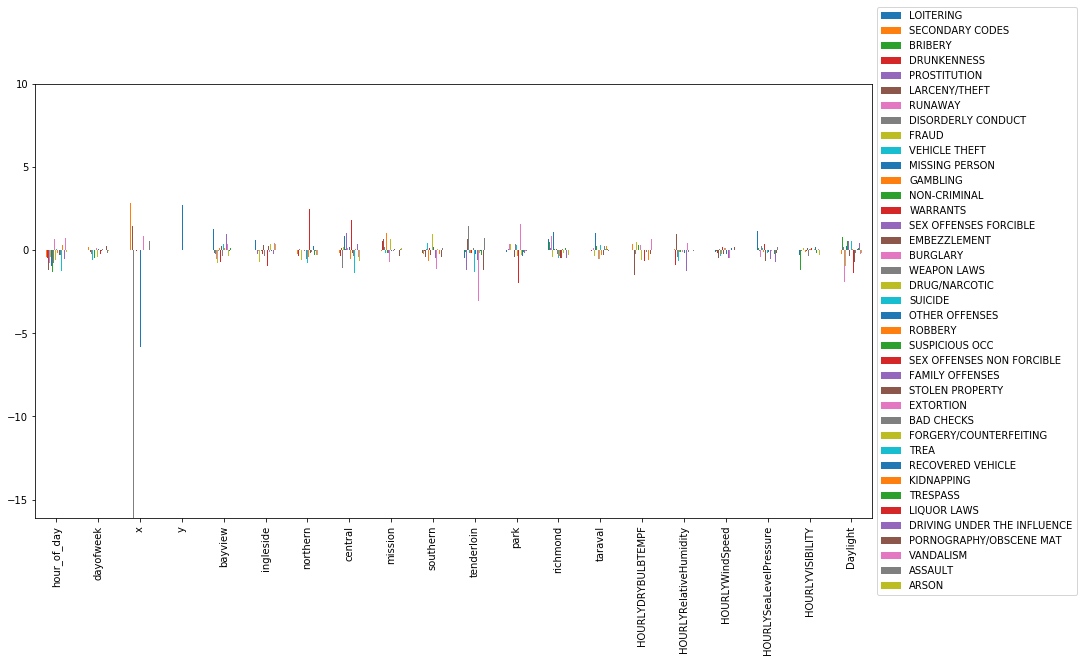

In [50]:
#%matplotlib inline
#import matplotlib.pyplot as plt
#
#f = plt.figure(figsize=(15,8))
#allCoefs.plot(kind='bar', figsize=(15,8))
#plt.legend(loc='center left', bbox_to_anchor=(1.0,0.5))
#plt.show()

## LR with L1-Penalty Hyperparameter Tuning

In [ ]:
lr_param_grid_1 = {'C': [0, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 5.0, 10.0]}
#lr_param_grid_1 = {'C': [0.0001, 0.01, 0.5, 5.0, 10.0]}
LR_l1 = GridSearchCV(LogisticRegression(penalty='l1'), param_grid=lr_param_grid_1, scoring='neg_log_loss')
LR_l1.fit(train_data, train_labels)

In [ ]:
print('L1: best C value:', str(LR_l1.best_params_['C']))

In [ ]:
LR_l1_prediction_probabilities = LR_l1.predict_proba(dev_data)
LR_l1_predictions = LR_l1.predict(dev_data)
print("L1 Multi-class Log Loss:", log_loss(y_true = dev_labels, y_pred = LR_l1_prediction_probabilities, labels = crime_labels), "\n\n")

## Dataframe for Coefficients

In [ ]:
columns = ['hour_of_day','dayofweek',\
          'x','y','bayview','ingleside','northern',\
          'central','mission','southern','tenderloin',\
          'park','richmond','taraval','HOURLYDRYBULBTEMPF',\
          'HOURLYRelativeHumidity','HOURLYWindSpeed',\
          'HOURLYSeaLevelPressure','HOURLYVISIBILITY',\
          'Daylight']

allCoefsL1 = pd.DataFrame(index=columns)
for a in range(len(LR_l1.coef_)):
    allCoefsL1[crime_labels[a]] = LR_l1.coef_[a]

allCoefsL1

## Plot for Coefficients

In [ ]:
f = plt.figure(figsize=(15,8))
allCoefsL1.plot(kind='bar', figsize=(15,8))
plt.legend(loc='center left', bbox_to_anchor=(1.0,0.5))
plt.show()

## LR with L2-Penalty Hyperparameter Tuning

In [ ]:
lr_param_grid_2 = {'C': [0, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 5.0, 10.0], \
                 'solver':['liblinear','newton-cg','lbfgs', 'sag']}
LR_l2 = GridSearchCV(LogisticRegression(penalty='l2'), param_grid=lr_param_grid_2, scoring='neg_log_loss')
LR_l2.fit(train_data, train_labels)

In [ ]:
print('L2: best C value:', str(LR_l2.best_params_['C']))
print('L2: best solver:', str(LR_l2.best_params_['solver']))

In [ ]:
LR_l2_prediction_probabilities = LR_l2.predict_proba(dev_data)
LR_l2_predictions = LR_l2.predict(dev_data)
print("L2 Multi-class Log Loss:", log_loss(y_true = dev_labels, y_pred = LR_l2_prediction_probabilities, labels = crime_labels), "\n\n")

## Dataframe for Coefficients

In [ ]:
columns = ['hour_of_day','dayofweek',\
          'x','y','bayview','ingleside','northern',\
          'central','mission','southern','tenderloin',\
          'park','richmond','taraval','HOURLYDRYBULBTEMPF',\
          'HOURLYRelativeHumidity','HOURLYWindSpeed',\
          'HOURLYSeaLevelPressure','HOURLYVISIBILITY',\
          'Daylight']

allCoefsL2 = pd.DataFrame(index=columns)
for a in range(len(LR_l2.coef_)):
    allCoefsL2[crime_labels[a]] = LR_l2.coef_[a]

allCoefsL2

## Plot of Coefficients

In [ ]:
f = plt.figure(figsize=(15,8))
allCoefsL2.plot(kind='bar', figsize=(15,8))
plt.legend(loc='center left', bbox_to_anchor=(1.0,0.5))
plt.show()